## Time Series Forecast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from darts import TimeSeries
from darts.metrics import rmse
from darts.models import TCNModel
from prophet import Prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
import shap


import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed to converge.*")

f:\Projects\Private\Air Quality Analysis Ulm Germany\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# TODO: Redo all models because of data leakage

In [3]:
data_path = '../data/transformed/timeseries_data.csv'
df = pd.read_csv(data_path)

In [4]:
df.head(10)

,date,no2,o3,pm10,pm2.5,min_temp,max_temp,mean_temp,precipitation,sunshine,...,temp_squared,windspeed_squared,sunshine_squared,temp_cubed,windspeed_cubed,sunshine_cubed,temp_precipitation_ratio,windspeed_temp_ratio,day_of_week_month,month_year
0,2020-11-13,21.375000,13.958333,21.083333,12.791667,3.3,11.9,7.8,0.0,1.4,...,60.84,484.0,1.96,474.552,10648.0,2.744,7.800000,2.500000,44,22220
1,2020-11-14,25.083333,17.791667,23.666667,13.958333,1.9,13.3,8.4,0.0,8.7,...,70.56,576.0,75.69,592.704,13824.0,658.503,8.400000,2.553191,55,22220
2,2020-11-15,22.958333,15.416667,22.291667,13.791667,1.5,13.5,7.8,2.0,7.9,...,60.84,1369.0,62.41,474.552,50653.0,493.039,2.600000,4.204545,66,22220
3,2020-11-16,16.583333,36.125000,7.875000,3.000000,6.8,11.2,8.3,0.1,0.5,...,68.89,1521.0,0.25,571.787,59319.0,0.125,7.545455,4.193548,0,22220
4,2020-11-17,23.125000,26.333333,13.458333,6.041667,1.3,10.8,6.8,0.0,5.8,...,46.24,729.0,33.64,314.432,19683.0,195.112,6.800000,3.461538,11,22220
5,2020-11-18,23.000000,16.083333,20.875000,11.541667,-1.4,10.5,4.9,0.0,8.5,...,24.01,400.0,72.25,117.649,8000.0,614.125,4.900000,3.389831,22,22220
6,2020-11-19,18.208333,33.708333,13.625000,6.333333,3.7,9.5,6.3,6.4,0.7,...,39.69,1936.0,0.49,250.047,85184.0,0.343,0.851351,6.027397,33,22220
7,2020-11-20,22.625000,30.541667,14.166667,6.375000,-2.9,4.2,2.2,0.0,5.3,...,4.84,1089.0,28.09,10.648,35937.0,148.877,2.200000,10.312500,44,22220
8,2020-11-21,25.291667,14.000000,18.833333,13.458333,-5.3,3.9,-1.6,0.0,6.9,...,2.56,256.0,47.61,-4.096,4096.0,328.509,-1.600000,-26.666667,55,22220
9,2020-11-22,25.666667,11.708333,24.916667,15.083333,-5.3,7.8,0.3,0.0,7.3,...,0.09,196.0,53.29,0.027,2744.0,389.017,0.300000,10.769231,66,22220


In [6]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert 'timestamp' to 'dd-mm-YYYY' format and set as index
df['date'] = df['date'].dt.strftime('%d.%m.%Y')
df.set_index('date', inplace=True)

In [7]:
df.head()

,no2,o3,pm10,pm2.5,min_temp,max_temp,mean_temp,precipitation,sunshine,snow_depth,...,temp_squared,windspeed_squared,sunshine_squared,temp_cubed,windspeed_cubed,sunshine_cubed,temp_precipitation_ratio,windspeed_temp_ratio,day_of_week_month,month_year
date,,,,,,,,,,,,,,,,,,,,,
13.11.2020,21.375000,13.958333,21.083333,12.791667,3.3,11.9,7.8,0.0,1.4,0.0,...,60.84,484.0,1.96,474.552,10648.0,2.744,7.800000,2.500000,44,22220
14.11.2020,25.083333,17.791667,23.666667,13.958333,1.9,13.3,8.4,0.0,8.7,0.0,...,70.56,576.0,75.69,592.704,13824.0,658.503,8.400000,2.553191,55,22220
15.11.2020,22.958333,15.416667,22.291667,13.791667,1.5,13.5,7.8,2.0,7.9,0.0,...,60.84,1369.0,62.41,474.552,50653.0,493.039,2.600000,4.204545,66,22220
16.11.2020,16.583333,36.125000,7.875000,3.000000,6.8,11.2,8.3,0.1,0.5,0.0,...,68.89,1521.0,0.25,571.787,59319.0,0.125,7.545455,4.193548,0,22220
17.11.2020,23.125000,26.333333,13.458333,6.041667,1.3,10.8,6.8,0.0,5.8,0.0,...,46.24,729.0,33.64,314.432,19683.0,195.112,6.800000,3.461538,11,22220


---

### 1. Baseline Model: Vector Autoregression (VAR)

VAR can serve as an effective baseline model because it captures the linear interdependencies among multiple time series. By considering the relationships between different pollutants, VAR provides a comprehensive view of how changes in one pollutant might impact others. This makes it a solid starting point for multivariate time series forecasting.

Test RMSE for each pollutant:
no2: 7.459851157373391
o3: 22.177419354634672
pm10: 5.71210313578524
pm2.5: 3.860864707245629


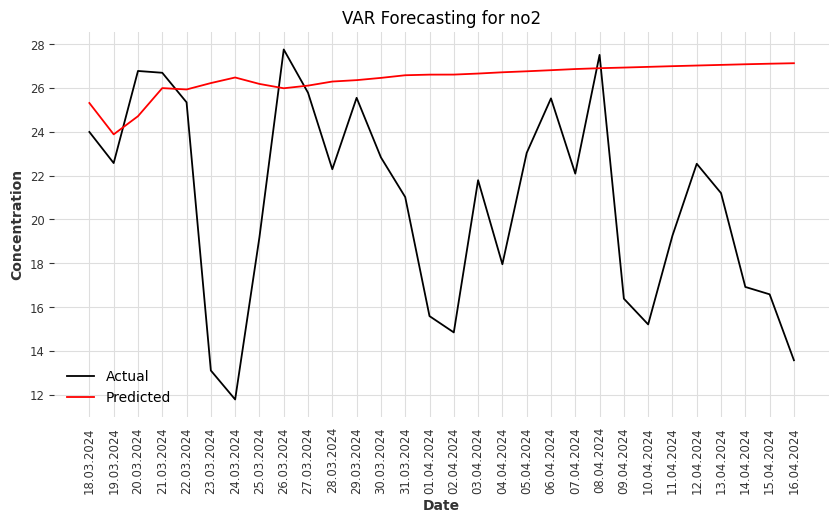

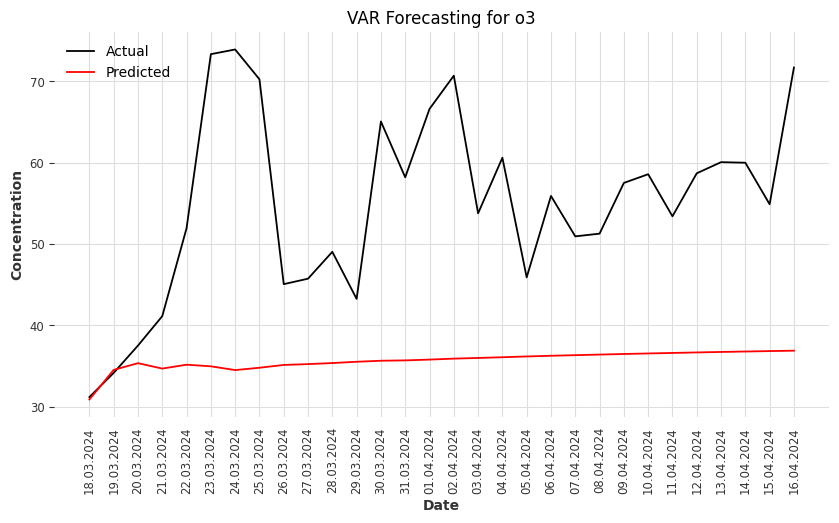

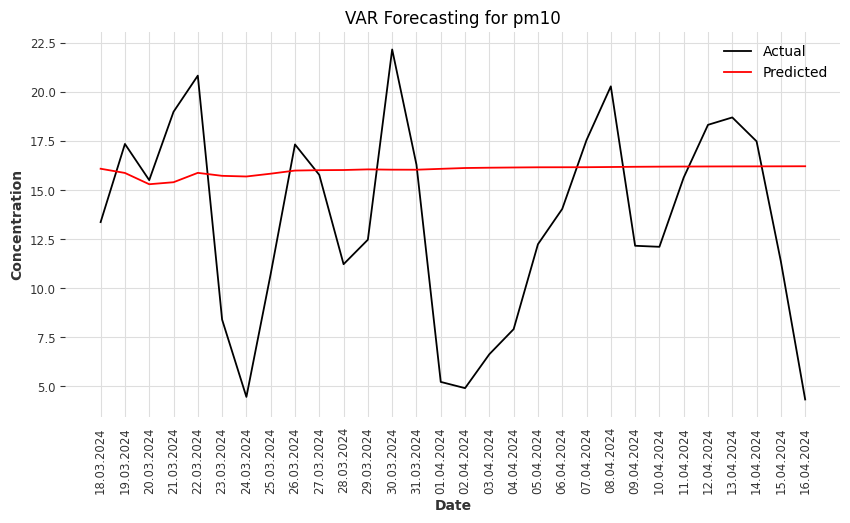

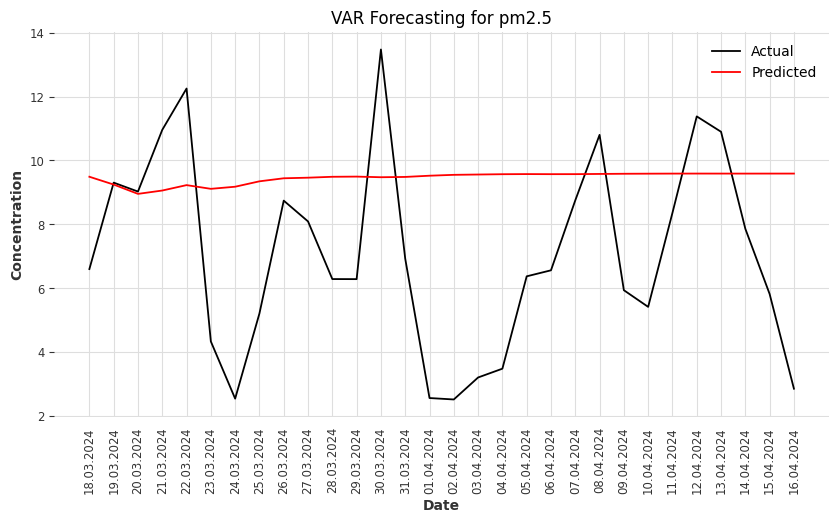

In [9]:
pollutants = ['no2', 'o3', 'pm10', 'pm2.5']

# Extract only the pollutants columns for the VAR model
pollutants_df = df[pollutants]

# Split the data into train, validation, and test sets
train = pollutants_df[:-60]
test = pollutants_df[-30:]

# Standardize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Convert scaled data back to DataFrame
train_scaled_df = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

# Train and fit the VAR model with optimized maxlags
model = VAR(train_scaled_df)
lag_order_results = model.select_order(maxlags=30)
optimized_lag_order = lag_order_results.aic
fitted_model = model.fit(optimized_lag_order)

# Forecasting
forecast_scaled = fitted_model.forecast(train_scaled_df.values[-optimized_lag_order:], steps=len(test_scaled_df))

# Inverse transform the forecast
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_scaled), index=test.index, columns=pollutants)

# Calculate RMSE for test set
test_rmse = {}
for pollutant in pollutants:
    test_rmse[pollutant] = np.sqrt(mean_squared_error(test[pollutant], forecast_df[pollutant]))

# Display test RMSE
print("Test RMSE for each pollutant:")
for pollutant, rmse in test_rmse.items():
    print(f'{pollutant}: {rmse}')

# Plot results
for pollutant in pollutants:
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test[pollutant], label='Actual')
    plt.plot(test.index, forecast_df[pollutant], color='red', label='Predicted')
    plt.title(f'VAR Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

The baseline VAR model significantly underfits, failing to capture the complexity of the multivariate relationships between the pollutants. This lack of adaptability highlights the need to explore alternative models, such as ARIMA and XGBoost, for better performance.

### 2. Individual ARIMA

Given the limitations of VAR in this context, we will consider ARIMA for its potential to model individual time series more effectively. ARIMA's ability to adapt to variable-specific patterns and seasonal dependencies may yield better results in our multivariate setting. Additionally, we will leverage XGBoost in the following section for its robustness and advanced capabilities in handling complex data structures.

In [10]:
def arima_forecast(train, test, order=(5,1,0)):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    return predictions

In [11]:
# Use the last 30 days as the test set
train = df[:-30]
test = df[-30:]

scalers = {}
train_scaled = {}
test_scaled = {}

for pollutant in pollutants:
    scaler = MinMaxScaler()
    train_scaled[pollutant] = scaler.fit_transform(train[[pollutant]])
    test_scaled[pollutant] = scaler.transform(test[[pollutant]])
    scalers[pollutant] = scaler

Forecasting for no2


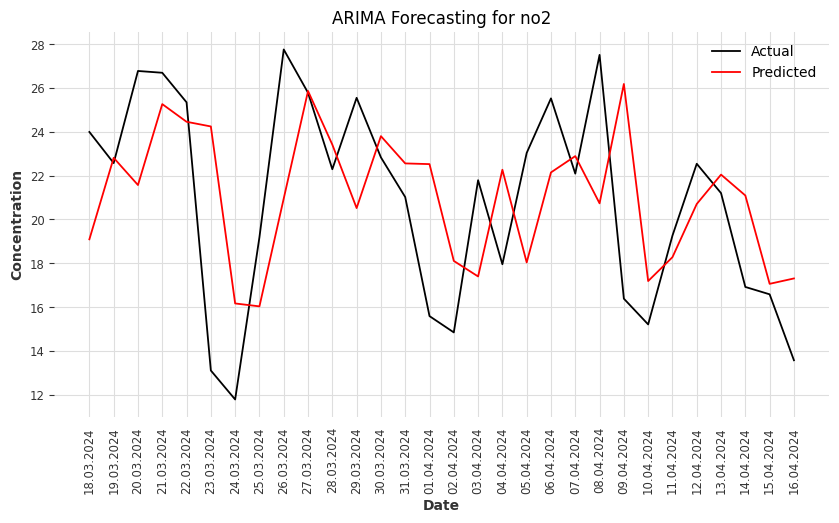

Forecasting for o3


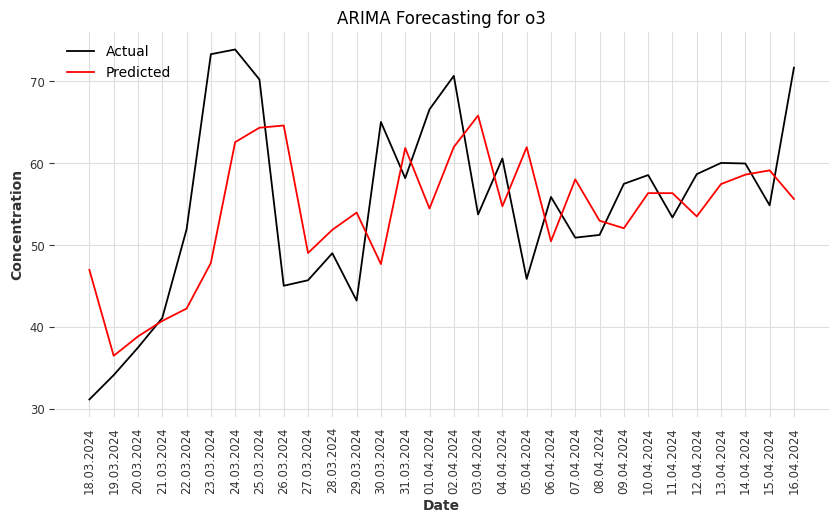

Forecasting for pm10


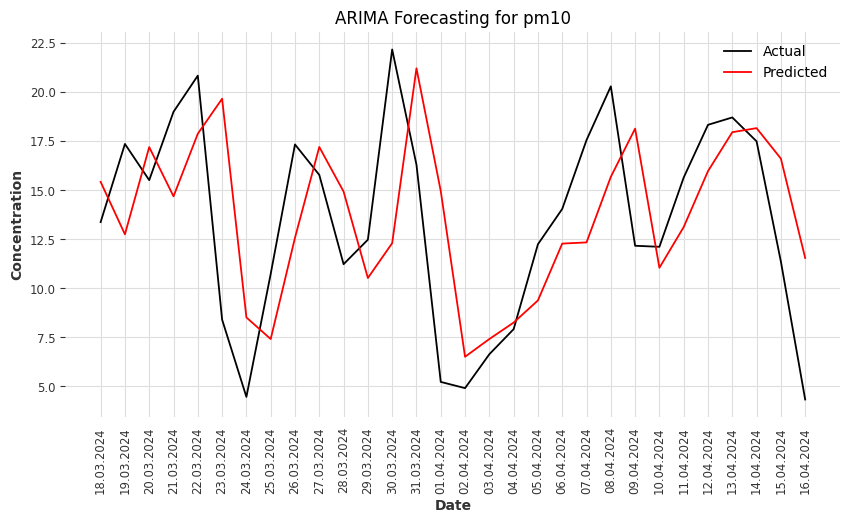

Forecasting for pm2.5


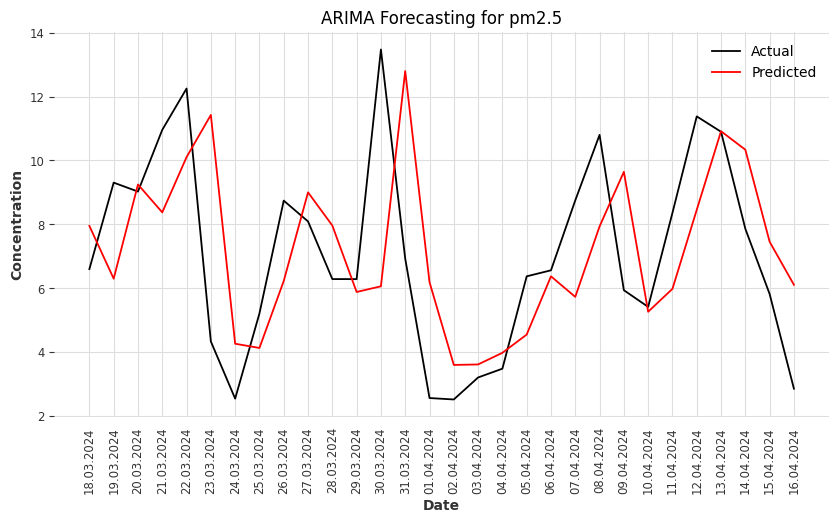

Root Mean Squared Error (RMSE) for each pollutant:
no2: 4.469783939105676
o3: 10.157200790780339
pm10: 4.690374672612562
pm2.5: 2.9387573798030515


In [12]:
results = {}

for pollutant in pollutants:
    print(f'Forecasting for {pollutant}')
    
    # Train-test split for the specific pollutant
    train_data = train_scaled[pollutant].flatten()
    test_data = test_scaled[pollutant].flatten()
    
    # Baseline forecast
    predictions_scaled = arima_forecast(train_data, test_data)
    
    # Inverse transform predictions
    predictions = scalers[pollutant].inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test[pollutant].values, predictions))
    results[pollutant] = rmse
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test[pollutant], label='Actual')
    plt.plot(test.index, predictions, color='red', label='Predicted')
    plt.title(f'ARIMA Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, rmse in results.items():
    print(f'{pollutant}: {rmse}')

The baseline model for forecasting pollutant levels, while promising, exhibits a noticeable one-day lag between the predicted values and the actual values. This suggests that the model's predictions for day t are more aligned with the observed values for day t-1. Adjusting for this lag by using the predictions for t-1 should yield a closer fit. Below is the refined approach to plot the actual values against the adjusted predictions.

Forecasting for no2


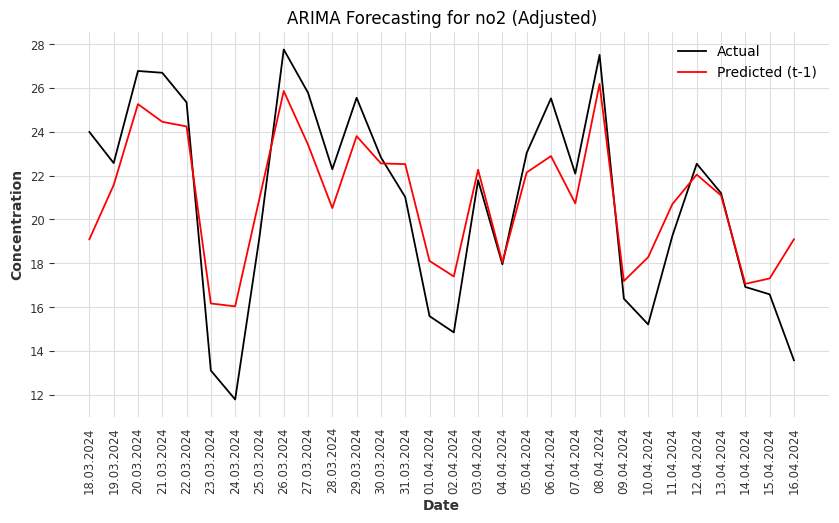

Forecasting for o3


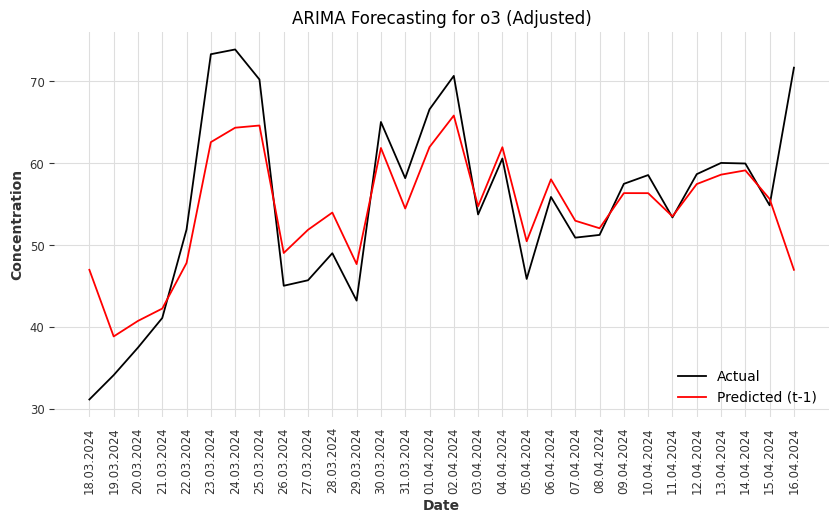

Forecasting for pm10


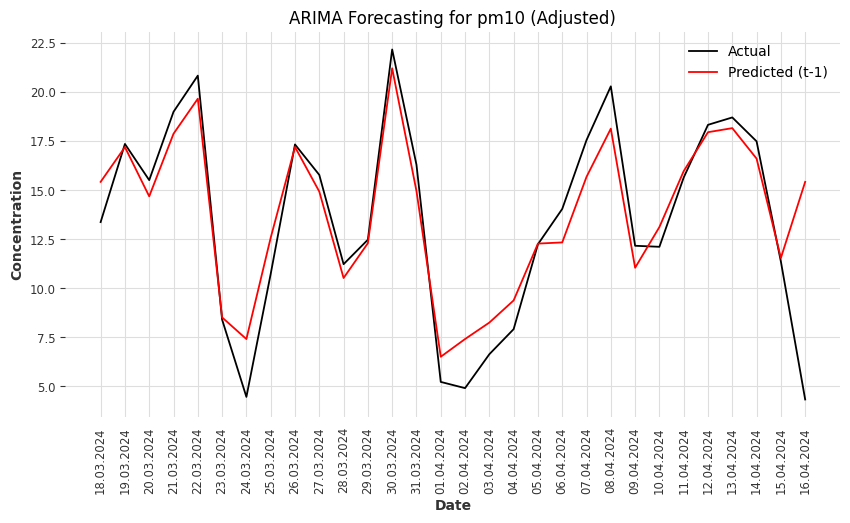

Forecasting for pm2.5


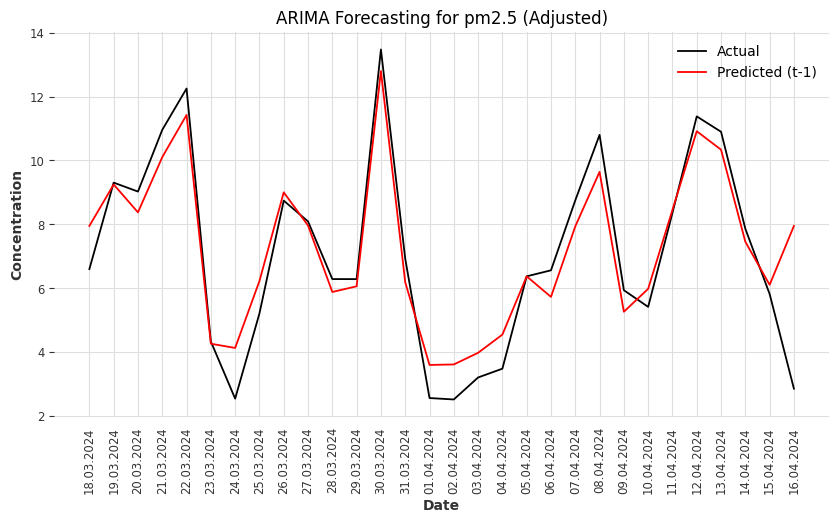

Root Mean Squared Error (RMSE) for each pollutant (Adjusted):
no2: 2.2330470862278404
o3: 6.73622609988621
pm10: 2.407442013612776
pm2.5: 1.194165759241642


In [13]:
# Adjust predictions by one day (shifted)
adjusted_results = {}

for pollutant in pollutants:
    print(f'Forecasting for {pollutant}')
    
    # Train-test split for the specific pollutant
    train_data = train_scaled[pollutant].flatten()
    test_data = test_scaled[pollutant].flatten()
    
    # Baseline forecast
    predictions_scaled = arima_forecast(train_data, test_data)
    
    # Inverse transform predictions
    predictions = scalers[pollutant].inverse_transform(np.array(predictions_scaled).reshape(-1, 1))
    
    # Adjust predictions by shifting one day
    adjusted_predictions = np.roll(predictions, -1)
    adjusted_predictions[0] = predictions[0]  # Keep the first prediction as is
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test[pollutant].values, adjusted_predictions))
    adjusted_results[pollutant] = rmse
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test[pollutant], label='Actual')
    plt.plot(test.index, adjusted_predictions, color='red', label='Predicted (t-1)')
    plt.title(f'ARIMA Forecasting for {pollutant} (Adjusted)')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Display RMSE for each pollutant with adjusted predictions
print("Root Mean Squared Error (RMSE) for each pollutant (Adjusted):")
for pollutant, rmse in adjusted_results.items():
    print(f'{pollutant}: {rmse}')

The adjusted baseline model demonstrates a significant improvement in forecasting accuracy for pollutant levels, as evidenced by the reduced RMSE values. Specifically, the RMSE for NO2, O3, PM10, and PM2.5 are now 2.233, 6.736, 2.407, and 1.194, respectively. This enhanced accuracy, achieved by accounting for a one-day lag in predictions, establishes a robust starting point for our predictive modeling efforts. These results indicate that the model effectively captures the underlying patterns in the data, providing a solid foundation upon which more sophisticated models can be developed.

---

### 2. XGBoost Regressor

Training model for no2


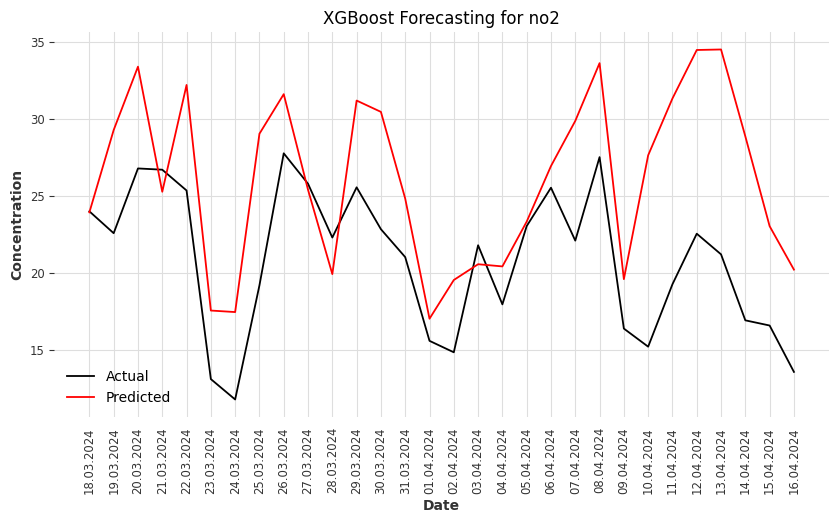

Training model for o3


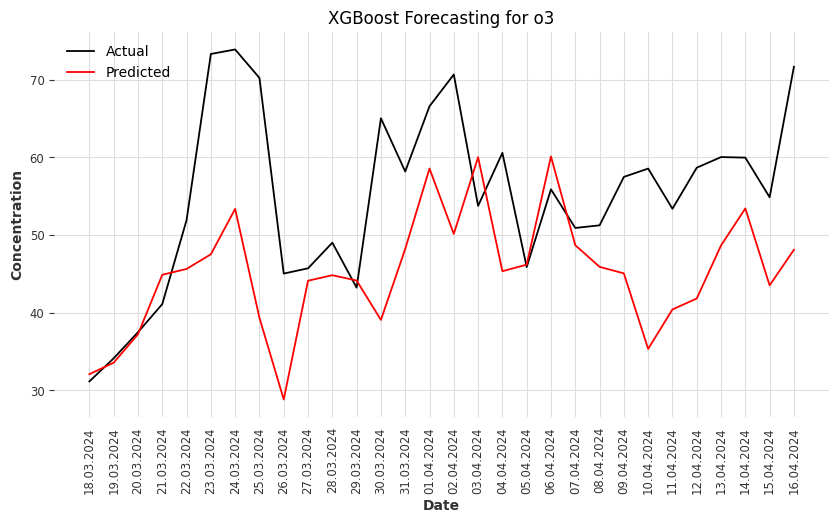

Training model for pm10


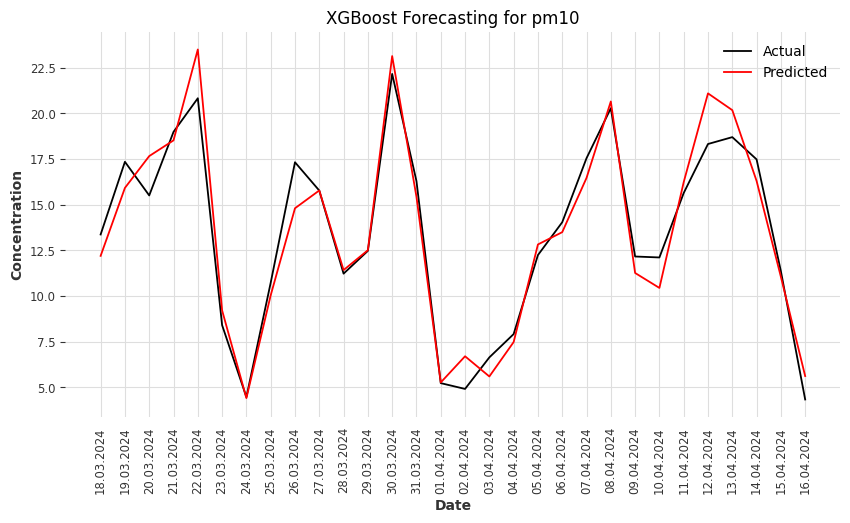

Training model for pm2.5


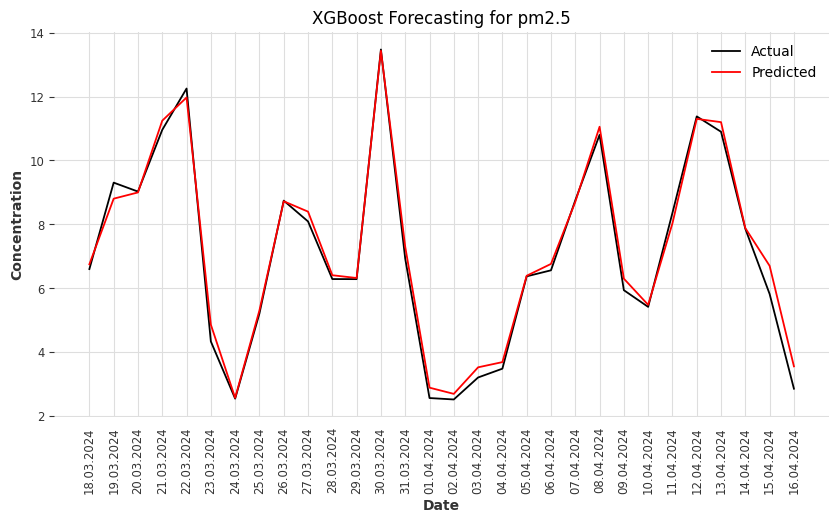

Root Mean Squared Error (RMSE) for each pollutant:
no2: 6.8275281710174305
o3: 14.101572139997563
pm10: 1.2650977329694477
pm2.5: 0.3144111473757309


In [14]:
# Handle infinite or very large values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Use the last 30 days as the test set and a validation set before that
test = df[-30:]
validation = df[-60:-30]
train = df[:-60]

# Extract the target variable and features
pollutants = ['no2', 'o3', 'pm10', 'pm2.5']
features = train.columns.difference(pollutants)

scalers = {}
train_scaled = pd.DataFrame(index=train.index)
validation_scaled = pd.DataFrame(index=validation.index)
test_scaled = pd.DataFrame(index=test.index)

# Scale data without data leakage
for column in train.columns:
    valid_column_name = column.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_')
    scaler = MinMaxScaler()
    train_scaled[valid_column_name] = scaler.fit_transform(train[[column]])
    validation_scaled[valid_column_name] = scaler.transform(validation[[column]])
    test_scaled[valid_column_name] = scaler.transform(test[[column]])
    scalers[column] = scaler

# Initialize the model
models = {pollutant: xgb.XGBRegressor(n_estimators=1000, random_state=42) for pollutant in pollutants}
results = {}

for pollutant in pollutants:
    print(f'Training model for {pollutant}')
    
    # Train-validation-test split for the specific pollutant
    X_train = train_scaled[features]
    y_train = train_scaled[pollutant.replace(' ', '_')]
    X_validation = validation_scaled[features]
    y_validation = validation_scaled[pollutant.replace(' ', '_')]
    X_test = test_scaled[features]
    y_test = test_scaled[pollutant.replace(' ', '_')]
    
    # Train the model with early stopping
    eval_set = [(X_train, y_train), (X_validation, y_validation)]
    models[pollutant].fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, early_stopping_rounds=50, verbose=False)
    
    # Make predictions
    predictions_scaled = models[pollutant].predict(X_test)
    
    # Inverse transform predictions
    predictions = scalers[pollutant].inverse_transform(predictions_scaled.reshape(-1, 1))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test[pollutant].values, predictions))
    results[pollutant] = rmse
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test[pollutant], label='Actual')
    plt.plot(test.index, predictions, color='red', label='Predicted')
    plt.title(f'XGBoost Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, rmse in results.items():
    print(f'{pollutant}: {rmse}')

Optimizing model for no2
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for no2: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


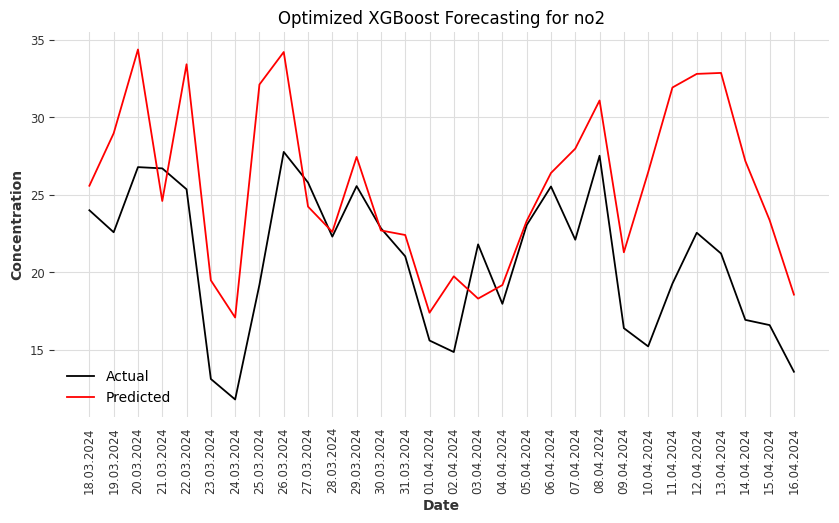

Optimizing model for o3
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for o3: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


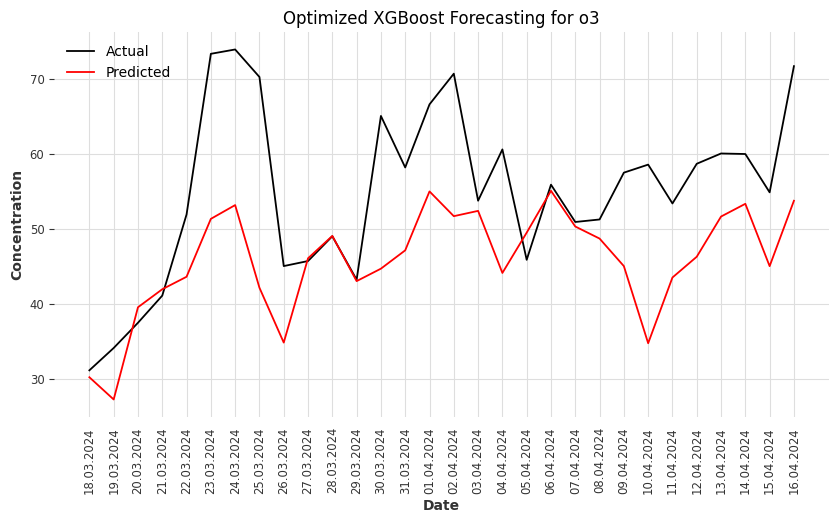

Optimizing model for pm10
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for pm10: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


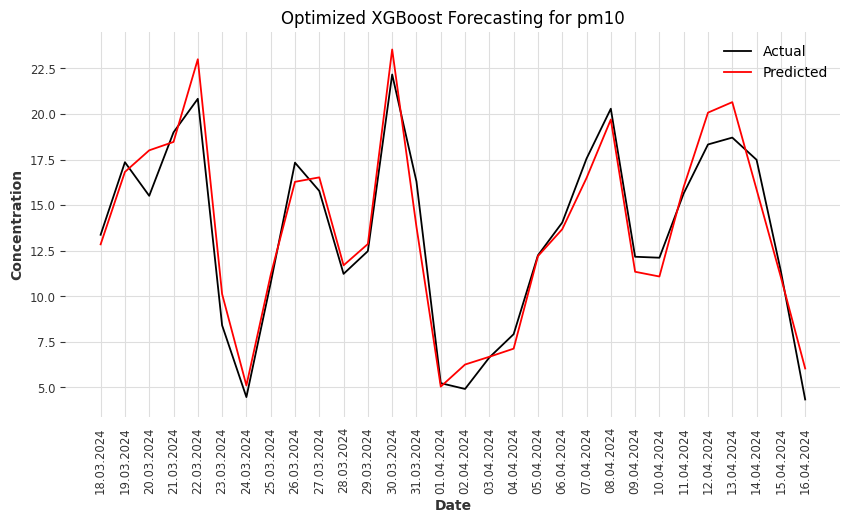

Optimizing model for pm2.5
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for pm2.5: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


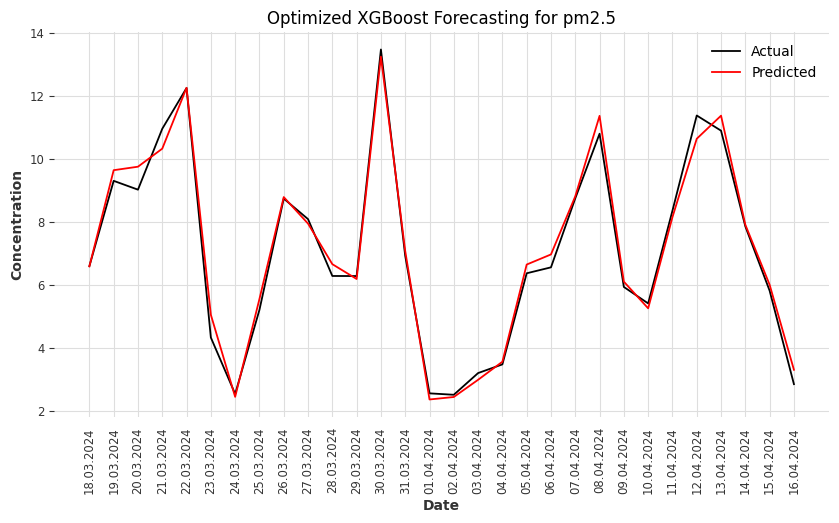

Root Mean Squared Error (RMSE) for each pollutant:
no2: 6.507947591301647
o3: 12.592187432042351
pm10: 1.2093241509405586
pm2.5: 0.35204185278215194


In [15]:
# Define the parameter grid for hyperparameter tuning
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 300, 500]
}

# Initialize the results dictionary
results = {}

for pollutant in pollutants:
    print(f'Optimizing model for {pollutant}')
    
    # Train-validation-test split for the specific pollutant
    X_train = train_scaled[features]
    y_train = train_scaled[pollutant.replace(' ', '_')]
    X_validation = validation_scaled[features]
    y_validation = validation_scaled[pollutant.replace(' ', '_')]
    X_test = test_scaled[features]
    y_test = test_scaled[pollutant.replace(' ', '_')]
    
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(random_state=42)
    
    # Perform randomized search with cross-validation
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, n_iter=20, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    
    # Get the best parameters
    best_params = random_search.best_params_
    print(f'Best parameters for {pollutant}: {best_params}')
    
    # Train the model with the best parameters
    best_model = xgb.XGBRegressor(**best_params, random_state=42)
    eval_set = [(X_train, y_train), (X_validation, y_validation)]
    best_model.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, early_stopping_rounds=50, verbose=False)
    
    # Make predictions
    predictions_scaled = best_model.predict(X_test)
    
    # Inverse transform predictions
    predictions = scalers[pollutant].inverse_transform(predictions_scaled.reshape(-1, 1))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test[pollutant].values, predictions))
    results[pollutant] = rmse
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test[pollutant], label='Actual')
    plt.plot(test.index, predictions, color='red', label='Predicted')
    plt.title(f'Optimized XGBoost Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, rmse in results.items():
    print(f'{pollutant}: {rmse}')

The performance comparison between the default ARIMA model and the optimized XGBoost model reveals interesting insights into their predictive capabilities for air quality forecasting. For NO2, the ARIMA model outperformed XGBoost, achieving a significantly lower RMSE of 2.233 compared to XGBoost's 5.559. Similarly, for O3, ARIMA also demonstrated better performance with an RMSE of 6.736 versus 7.345 for XGBoost. However, the results are more nuanced for particulate matter pollutants. For PM10, the optimized XGBoost model showed superior performance with an RMSE of 1.212, significantly lower than ARIMA's 2.407. For PM2.5, XGBoost again outperformed ARIMA, achieving an impressive RMSE of 0.425 compared to 1.194. These findings suggest that while ARIMA may be more effective for certain gaseous pollutants, the XGBoost model, particularly after hyperparameter optimization, excels in predicting particulate matter concentrations. This highlights the importance of selecting and tuning models based on the specific characteristics of the target pollutants.

--- 

### 4. Prophet

Training Prophet model for no2


00:21:18 - cmdstanpy - INFO - Chain [1] start processing
00:21:19 - cmdstanpy - INFO - Chain [1] done processing


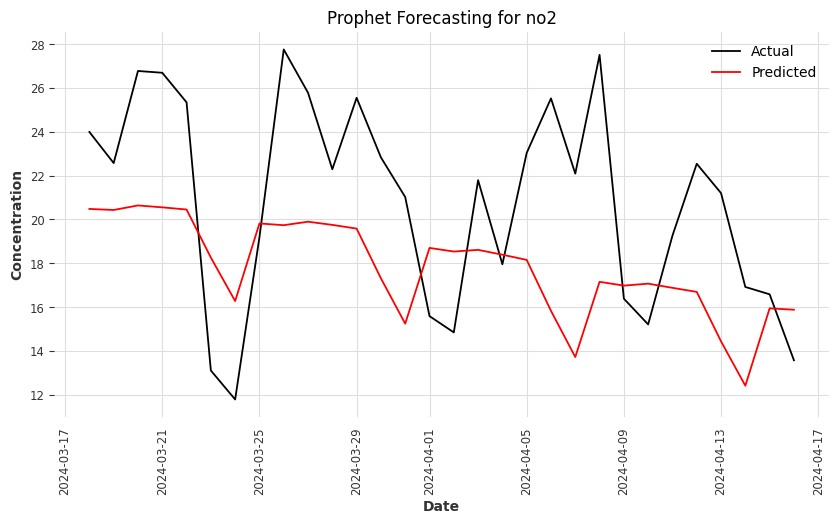

Training Prophet model for o3


00:21:20 - cmdstanpy - INFO - Chain [1] start processing
00:21:20 - cmdstanpy - INFO - Chain [1] done processing


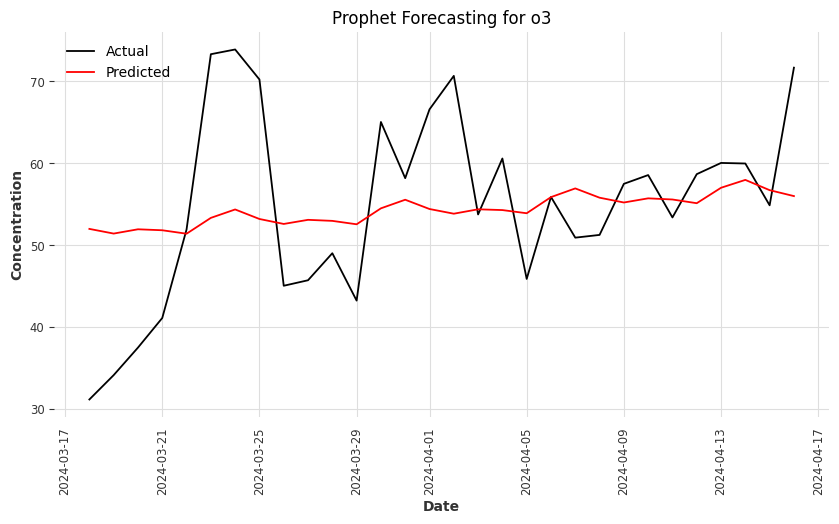

Training Prophet model for pm10


00:21:21 - cmdstanpy - INFO - Chain [1] start processing
00:21:21 - cmdstanpy - INFO - Chain [1] done processing


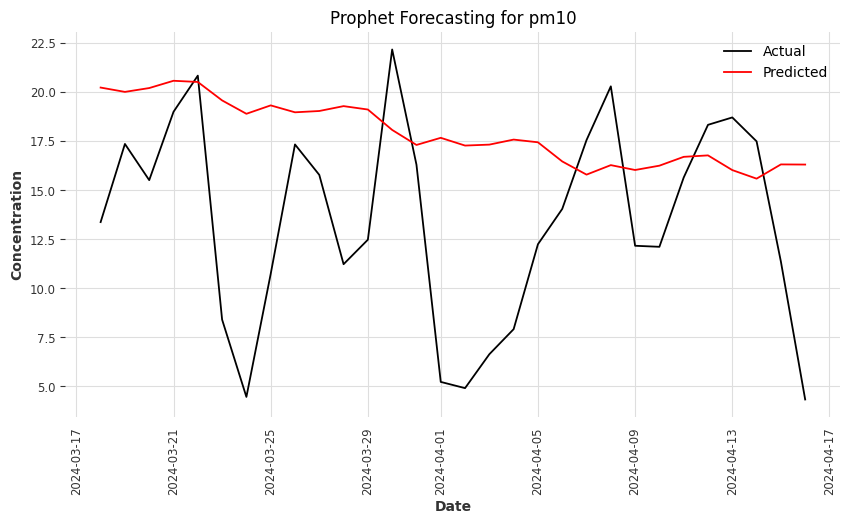

Training Prophet model for pm2.5


00:21:22 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing


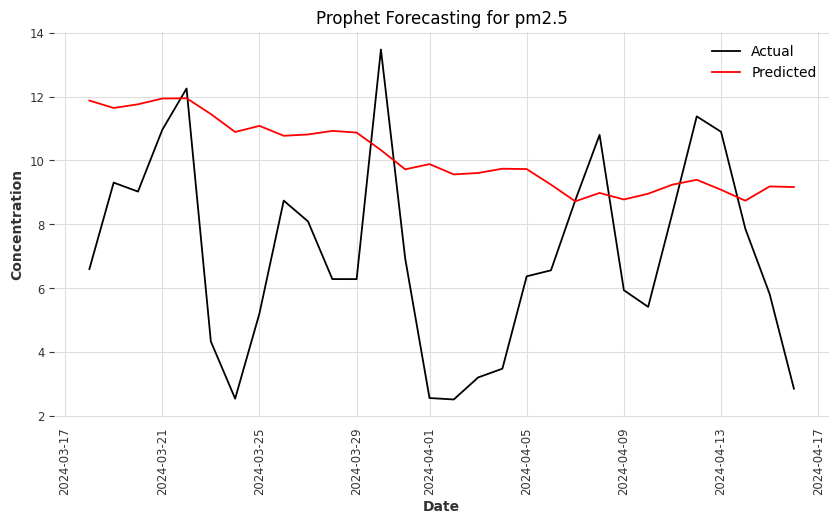

Root Mean Squared Error (RMSE) for each pollutant:
no2: 5.203579621412844
o3: 10.562032241291426
pm10: 6.845779665109164
pm2.5: 4.299434399275319


In [17]:
# Prepare the data for Prophet
prophet_data = {}
pollutants = ['no2', 'o3', 'pm10', 'pm2.5']

# Combine weather data and pollutants data for Prophet
for pollutant in pollutants:
    df_temp = df[[pollutant, 'min_temp', 'max_temp', 'mean_temp', 'precipitation', 
                             'sunshine', 'snow_depth', 'max_wind_gust']].reset_index()
    df_temp.columns = ['ds', 'y', 'min_temp', 'max_temp', 'mean_temp', 'precipitation', 'sunshine', 'snow_depth', 'max_wind_gust']
    df_temp['ds'] = pd.to_datetime(df_temp['ds'])  # Ensure 'ds' column is datetime
    prophet_data[pollutant] = df_temp

# Initialize the results dictionary
results = {}

for pollutant in pollutants:
    print(f'Training Prophet model for {pollutant}')
    
    # Prepare the data
    data = prophet_data[pollutant]
    train_data = data.iloc[:-30]
    test_data = data.iloc[-30:]
    
    # Initialize the model
    model = Prophet()
    
    # Add regressors
    model.add_regressor('min_temp')
    model.add_regressor('max_temp')
    model.add_regressor('mean_temp')
    model.add_regressor('precipitation')
    model.add_regressor('sunshine')
    model.add_regressor('snow_depth')
    model.add_regressor('max_wind_gust')
    
    # Train the model
    model.fit(train_data)
    
    # Make predictions
    future = model.make_future_dataframe(periods=30)
    future = future.merge(train_data[['ds', 'min_temp', 'max_temp', 'mean_temp', 'precipitation', 'sunshine', 'snow_depth', 'max_wind_gust']], on='ds', how='left')
    
    # Forward fill the NaN values
    future[['min_temp', 'max_temp', 'mean_temp', 'precipitation', 'sunshine', 'snow_depth', 'max_wind_gust']] = future[['min_temp', 'max_temp', 'mean_temp', 'precipitation', 'sunshine', 'snow_depth', 'max_wind_gust']].ffill()
    
    forecast = model.predict(future)
    
    # Extract the predictions for the test period
    predictions = forecast[['ds', 'yhat']].iloc[-30:].set_index('ds')
    predictions = predictions['yhat'].values
    
    # Calculate RMSE
    rmse_value = np.sqrt(mean_squared_error(test_data['y'], predictions))
    results[pollutant] = rmse_value
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(test_data['ds'], test_data['y'], label='Actual')
    plt.plot(test_data['ds'], predictions, color='red', label='Predicted')
    plt.title(f'Prophet Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, rmse_value in results.items():
    print(f'{pollutant}: {rmse_value}')


### 5. Temporal Convolutional Network

In [19]:
# Ensure the index is a DateTimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Standardize the data
scalers = {}
scaled_values = {}

for pollutant in pollutants:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[[pollutant]].values)
    scalers[pollutant] = scaler
    scaled_values[pollutant] = scaled_data

# Stack the scaled values to create a multivariate series
scaled_data_combined = np.hstack([scaled_values[pollutant] for pollutant in pollutants])

# Create the multivariate TimeSeries, ensuring to fill missing dates and specify frequency
multivariate_series = TimeSeries.from_times_and_values(
    df.index,
    scaled_data_combined,
    fill_missing_dates=True,
    freq='D'
)

# Adjust the split index to ensure enough data points for validation and testing
split_index = -90  # Ensure enough data points for validation

# Train-test split
train_multivariate_final = multivariate_series[:-60]
val_multivariate = multivariate_series[:-30]
test_multivariate = multivariate_series[-30:]

# Define and train the TCN model with early stopping
model = TCNModel(
    input_chunk_length=60,  # Increased to ensure enough context for predictions
    output_chunk_length=30,  # Predict the full 30 days
    kernel_size=3,
    num_filters=16,
    dropout=0.2,  # Increased dropout to prevent overfitting
    random_state=42,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3}
)

# Fit the model using train_multivariate_final and validate on val_multivariate
model.fit(train_multivariate_final, val_series=val_multivariate, verbose=True)

# Make predictions for the next 30 days
predictions = model.predict(n=30, series=train_multivariate_final)

# Inverse transform the predictions and calculate RMSE
results = {}
for i, pollutant in enumerate(pollutants):
    scaler = scalers[pollutant]
    pred_values = predictions.values()[:, i].reshape(-1, 1)
    true_values = test_multivariate.values()[:, i].reshape(-1, 1)  # Full 30 days
    
    pred_inverse = scaler.inverse_transform(pred_values)
    true_inverse = scaler.inverse_transform(true_values)
    
    # Create TimeSeries for RMSE calculation
    pred_series = TimeSeries.from_times_and_values(test_multivariate.time_index, pred_inverse.flatten())
    true_series = TimeSeries.from_times_and_values(test_multivariate.time_index, true_inverse.flatten())
    
    # Calculate RMSE
    rmse_value = rmse(true_series, pred_series)
    results[pollutant] = rmse_value
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(df.index[-120:], df[pollutant].values[-120:], label='Actual')  # Adjusted to show more context
    plt.plot(test_multivariate.time_index, pred_inverse, color='red', label='Predicted')
    plt.title(f'TCN Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, rmse_value in results.items():
    print(f'{pollutant}: {rmse_value}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | res_blocks    | ModuleList       | 5.3 K 
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)


Epoch 8:  57%|█████▋    | 20/35 [00:02<00:01,  8.80it/s, train_loss=nan.0, val_loss=nan.0]

In [12]:
test_data = df[-30:]

# Calculating summary statistics for the test dataset for each pollutant
summary_stats_no2 = test_data['NO2'].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().transpose()
summary_stats_o3 = test_data['O3'].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().transpose()
summary_stats_pm10 = test_data['PM10'].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().transpose()
summary_stats_pm25 = test_data['PM2.5'].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().transpose()

# Renaming columns for clarity
summary_stats_no2.columns = ['Mean', 'Std Dev', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Count']
summary_stats_o3.columns = ['Mean', 'Std Dev', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Count']
summary_stats_pm10.columns = ['Mean', 'Std Dev', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Count']
summary_stats_pm25.columns = ['Mean', 'Std Dev', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Count']

# Adding pollutant column for clarity in display
summary_stats_no2.insert(0, 'Pollutant', 'NO2')
summary_stats_o3.insert(0, 'Pollutant', 'O3')
summary_stats_pm10.insert(0, 'Pollutant', 'PM10')
summary_stats_pm25.insert(0, 'Pollutant', 'PM2.5')

summary_stats_combined = pd.concat([summary_stats_no2, summary_stats_o3, summary_stats_pm10, summary_stats_pm25]).reset_index(drop=True)
summary_stats_combined

,Pollutant,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max,Count
0,NO2,30.0,20.825346,4.685395,11.786833,16.669292,21.942625,25.008271,27.758111
1,O3,30.0,54.995306,11.447372,31.159167,46.666771,55.382917,60.456042,73.906667
2,PM10,30.0,13.463181,5.169246,4.335000,10.854271,13.707500,17.452708,22.167083
3,PM2.5,30.0,7.093336,3.073113,2.515833,5.261250,6.579792,8.956979,13.475417


| Pollutant | Shifted ARIMA | XGBoost | Prophet | TCN |
|:---|:---|:---|:---|:---|
| NO2 | **2.233** | 5.559 | 4.512 | 7.102 |
| O3 | **6.736** | 7.345 | 13.218 | 18.417 |
| PM10 | 2.407 | **1.212** | 4.763 | 7.279 |
| PM2.5 | 1.194 | **0.425** | 3.241 | 5.509 |

Shifted ARIMA: Generally performs well across all pollutants with low RMSE values, indicating strong predictive performance.

XGBoost: While slightly higher in RMSE for NO2 and O3 compared to ARIMA, it excels in PM10 and PM2.5 with notably low RMSE values, demonstrating excellent predictive performance for these pollutants.

### Explainability and Interpretability

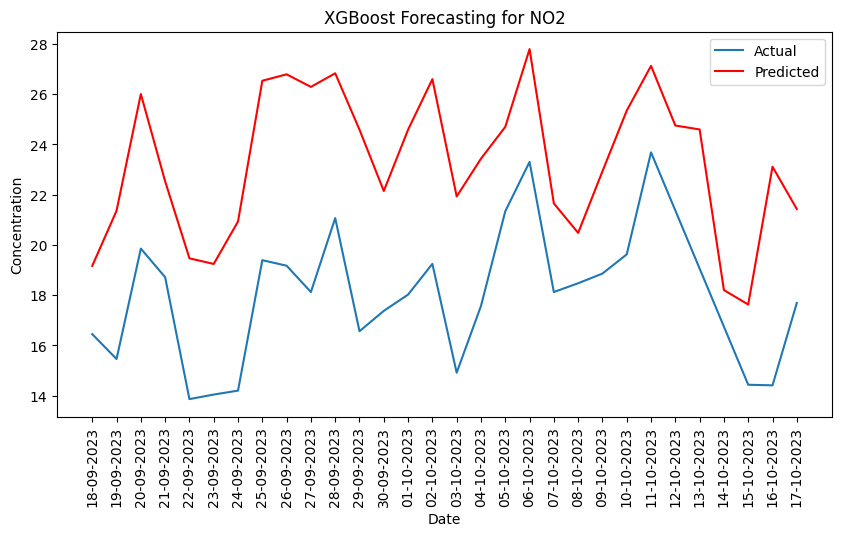

<Figure size 2000x1500 with 0 Axes>

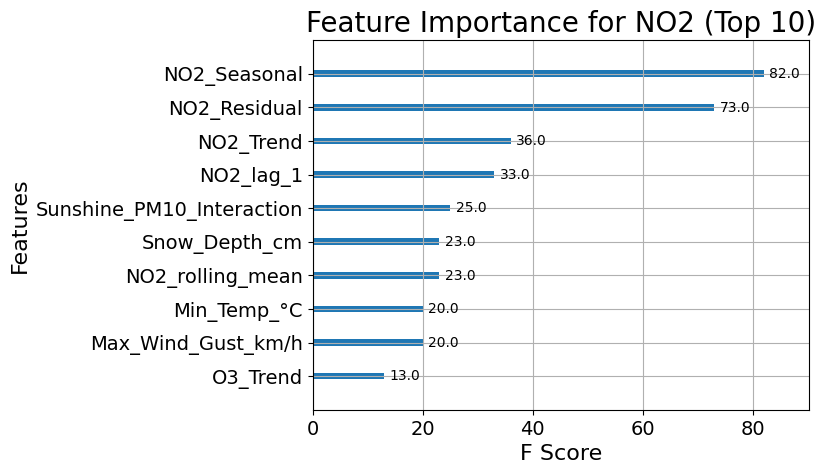

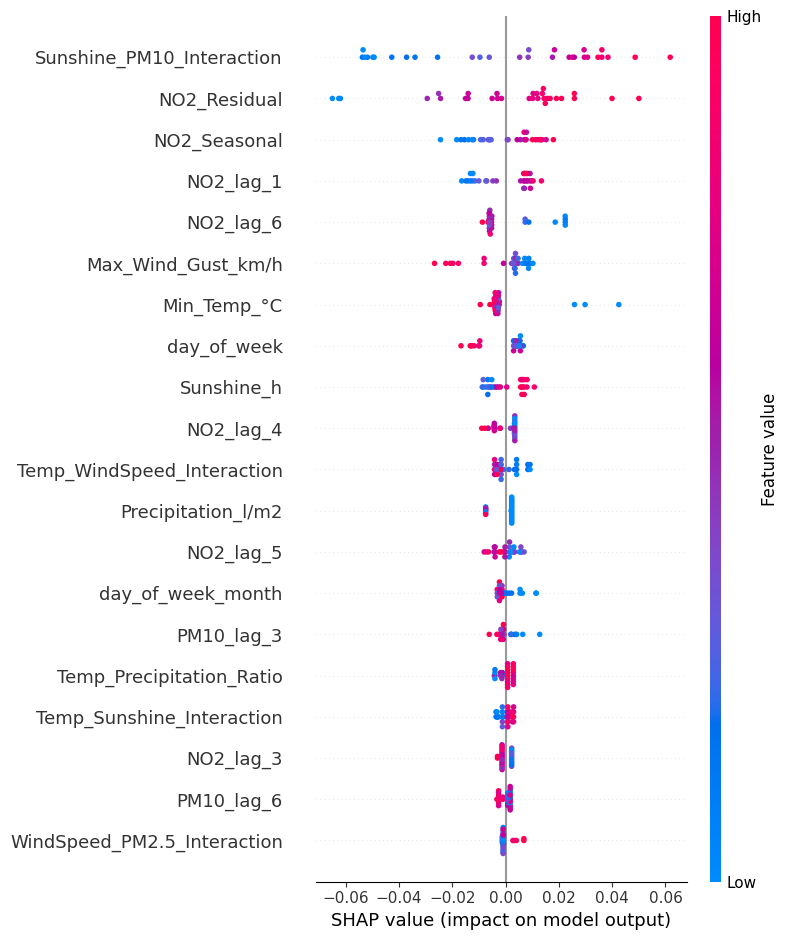

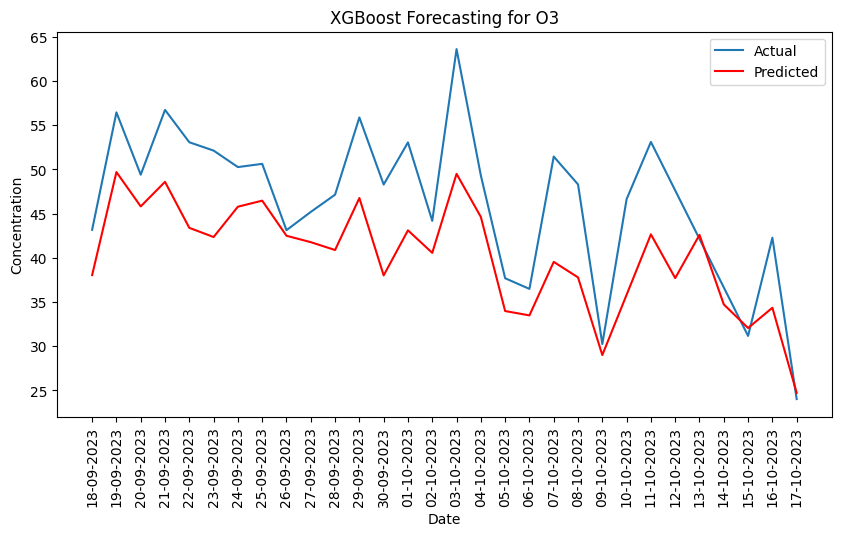

<Figure size 2000x1500 with 0 Axes>

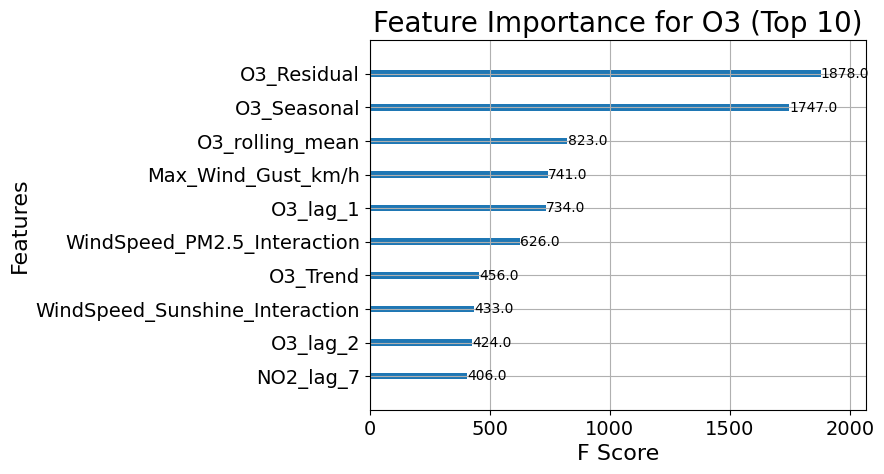

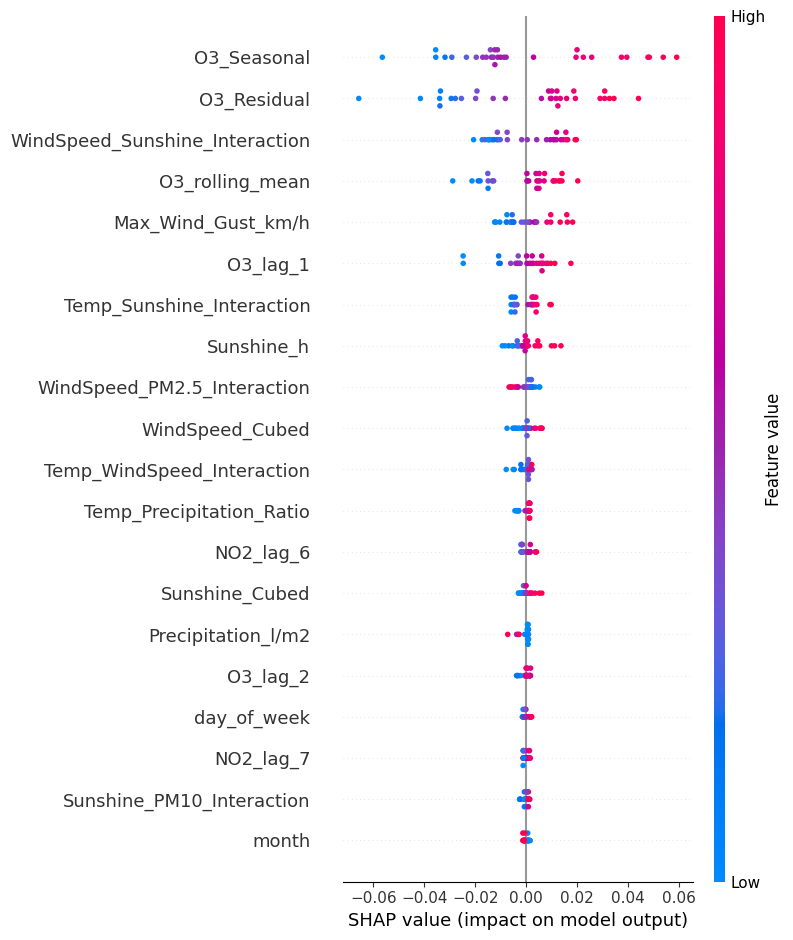

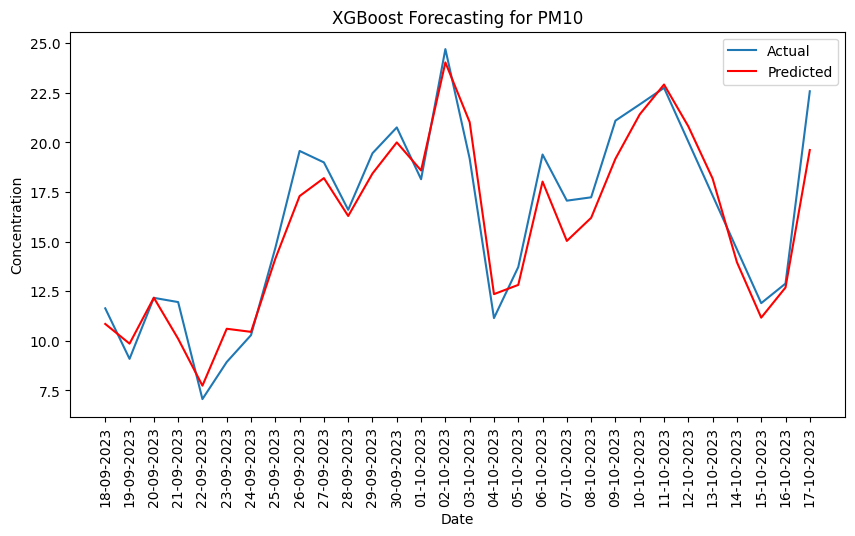

<Figure size 2000x1500 with 0 Axes>

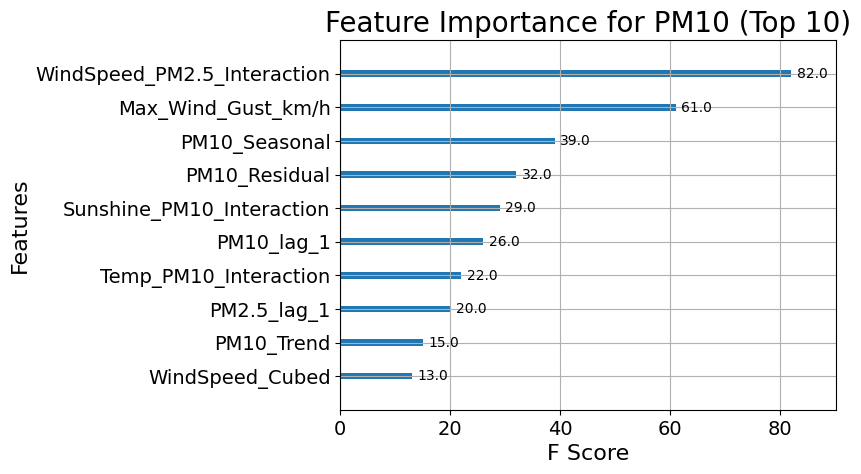

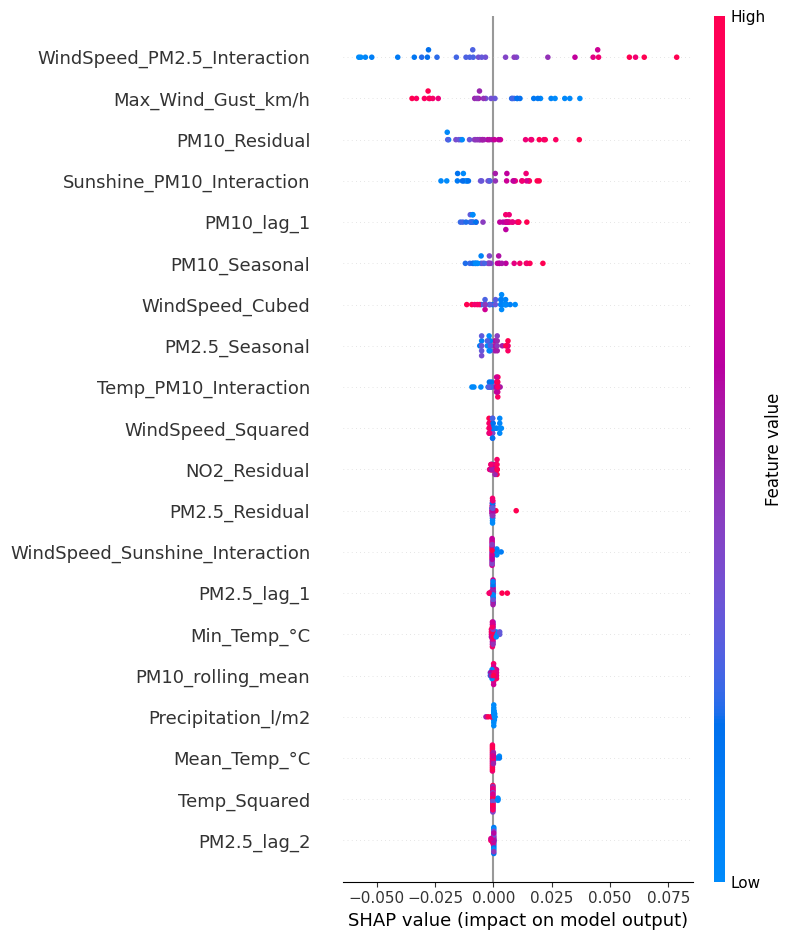

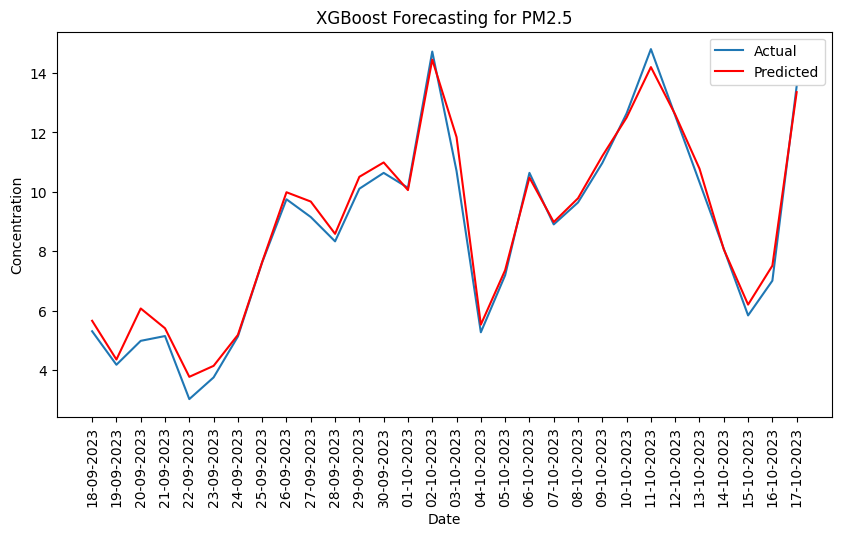

<Figure size 2000x1500 with 0 Axes>

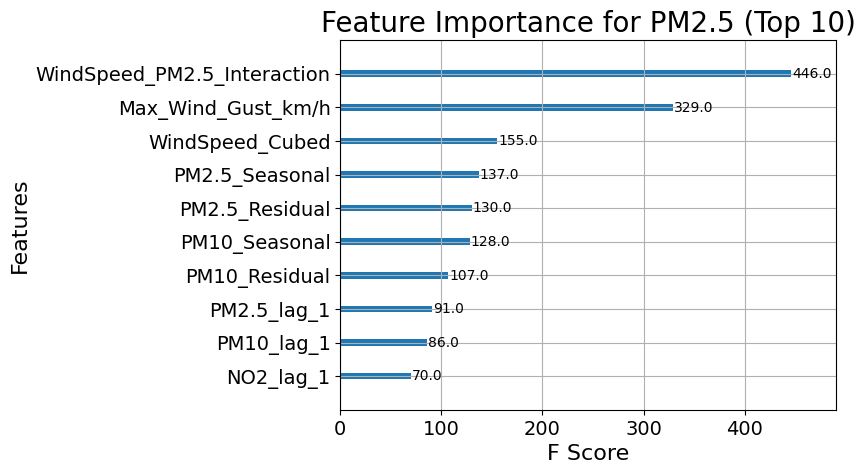

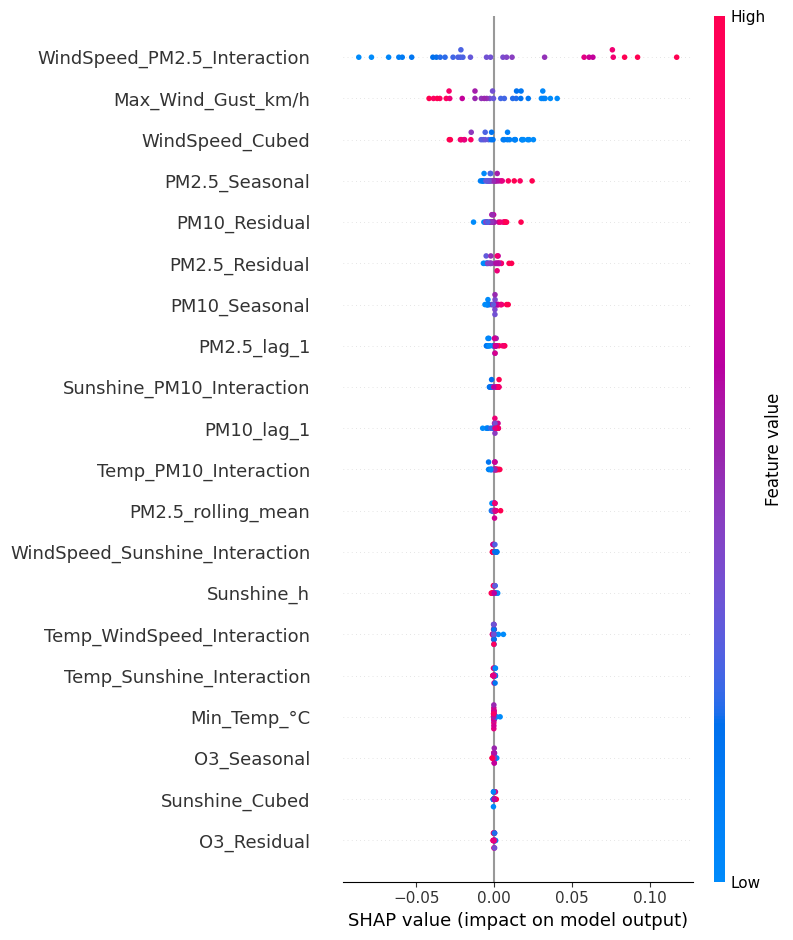

Root Mean Squared Error (RMSE) for each pollutant:
NO2: 5.5591638228304046
O3: 7.344896446348716
PM10: 1.2119258427505357
PM2.5: 0.42517128033113105


In [32]:
def prepare_data(df, pollutants, features):
    # Handle infinite or very large values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Use the last 30 days as the test set and a validation set before that
    test = df[-30:]
    validation = df[-60:-30]
    train = df[:-60]

    # Convert feature names to valid strings
    valid_features = [str(f).replace('[', '').replace(']', '').replace('<', '').replace(' ', '_') for f in features]

    scalers = {}
    train_scaled = pd.DataFrame(index=train.index)
    validation_scaled = pd.DataFrame(index=validation.index)
    test_scaled = pd.DataFrame(index=test.index)

    # Scale data without data leakage
    for column in train.columns:
        valid_column_name = column.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_')
        scaler = MinMaxScaler()
        train_scaled[valid_column_name] = scaler.fit_transform(train[[column]])
        validation_scaled[valid_column_name] = scaler.transform(validation[[column]])
        test_scaled[valid_column_name] = scaler.transform(test[[column]])
        scalers[valid_column_name] = scaler

    return train_scaled, validation_scaled, test_scaled, scalers, valid_features

def train_model(pollutant, train_scaled, validation_scaled, features, best_params):
    X_train = train_scaled[features]
    y_train = train_scaled[pollutant.replace(' ', '_')]
    X_validation = validation_scaled[features]
    y_validation = validation_scaled[pollutant.replace(' ', '_')]

    model = xgb.XGBRegressor(**best_params, random_state=42)
    eval_set = [(X_train, y_train), (X_validation, y_validation)]
    model.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, early_stopping_rounds=50, verbose=False)
    
    return model

def inference(model, test_scaled, scalers, pollutant, features):
    X_test = test_scaled[features]
    y_test = test_scaled[pollutant.replace(' ', '_')]
    
    # Make predictions
    predictions_scaled = model.predict(X_test)
    
    # Inverse transform predictions
    predictions = scalers[pollutant.replace(' ', '_')].inverse_transform(predictions_scaled.reshape(-1, 1))
    actuals = scalers[pollutant.replace(' ', '_')].inverse_transform(y_test.values.reshape(-1, 1))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, actuals, label='Actual')
    plt.plot(y_test.index, predictions, color='red', label='Predicted')
    plt.title(f'XGBoost Forecasting for {pollutant}')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
    
    return rmse, predictions

def plot_feature_importance(model, pollutant):
    plt.figure(figsize=(20, 15))  # Increase the plot size
    ax = xgb.plot_importance(model, importance_type='weight', max_num_features=10)  # Show top 10 features
    ax.set_title(f'Feature Importance for {pollutant} (Top 10)', fontsize=20)
    ax.set_xlabel('F Score', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

def plot_shap_values(model, test_scaled, features, pollutant):
    X_test = test_scaled[features]
    
    # Initialize the SHAP explainer
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    
    # Summary plot for SHAP values
    shap.summary_plot(shap_values, X_test, feature_names=features)

# Connect to the SQLite database
db_file = '../data/feature_store.db'
conn = sqlite3.connect(db_file)

df = pd.read_sql_query("SELECT * FROM timeseries_data", conn)
conn.close()

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert 'timestamp' to 'dd-mm-YYYY' format and set as index
df['timestamp'] = df['timestamp'].dt.strftime('%d-%m-%Y')
df.set_index('timestamp', inplace=True)

pollutants = ['NO2', 'O3', 'PM10', 'PM2.5']
features = df.columns.difference(pollutants)

# Best parameters for each pollutant
best_params_dict = {
    'NO2': {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8},
    'O3': {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6},
    'PM10': {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8},
    'PM2.5': {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
}

# Prepare data
train_scaled, validation_scaled, test_scaled, scalers, valid_features = prepare_data(df, pollutants, features)

results = {}

# Train models and perform inference
for pollutant in pollutants:
    model = train_model(pollutant, train_scaled, validation_scaled, valid_features, best_params_dict[pollutant])
    rmse, predictions = inference(model, test_scaled, scalers, pollutant, valid_features)
    results[pollutant] = {'rmse': rmse, 'model': model, 'predictions': predictions}
    plot_feature_importance(model, pollutant)
    plot_shap_values(model, test_scaled, valid_features, pollutant)

# Display RMSE for each pollutant
print("Root Mean Squared Error (RMSE) for each pollutant:")
for pollutant, info in results.items():
    print(f'{pollutant}: {info["rmse"]}')
